In [13]:
from pyspark.sql import SparkSession

In [14]:
spark = SparkSession.builder.appName("PySpark MLLib").getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

25/07/04 11:48:21 WARN Utils: Your hostname, Anirbans-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.0.149 instead (on interface en0)
25/07/04 11:48:21 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/04 11:48:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [15]:
# Import the library for ALS
from pyspark.mllib.recommendation import ALS, Rating


In [16]:
# Import the library for Logistic Regression
from pyspark.mllib.classification import LogisticRegressionWithLBFGS

In [17]:
# Import the library for Kmeans
from pyspark.mllib.clustering import KMeans

In [18]:
sc = spark.sparkContext

### Collaborative Filtering

In [19]:
# Load the data into RDD
data = sc.textFile("ratings.csv")

In [20]:
data.count()

100004

In [21]:
data.take(10)

['1,31,2.5,1260759144',
 '1,1029,3.0,1260759179',
 '1,1061,3.0,1260759182',
 '1,1129,2.0,1260759185',
 '1,1172,4.0,1260759205',
 '1,1263,2.0,1260759151',
 '1,1287,2.0,1260759187',
 '1,1293,2.0,1260759148',
 '1,1339,3.5,1260759125',
 '1,1343,2.0,1260759131']

In [22]:
# Split the RDD 
ratings = data.map(lambda l: l.split(','))

In [23]:
ratings.take(10)

[['1', '31', '2.5', '1260759144'],
 ['1', '1029', '3.0', '1260759179'],
 ['1', '1061', '3.0', '1260759182'],
 ['1', '1129', '2.0', '1260759185'],
 ['1', '1172', '4.0', '1260759205'],
 ['1', '1263', '2.0', '1260759151'],
 ['1', '1287', '2.0', '1260759187'],
 ['1', '1293', '2.0', '1260759148'],
 ['1', '1339', '3.5', '1260759125'],
 ['1', '1343', '2.0', '1260759131']]

In [24]:
# Transform the ratings RDD 
ratings_final = ratings.map(lambda line: Rating(int(line[0]), 
                                    int(line[1]), float(line[2])))

In [25]:
ratings_final.take(10)

[Rating(user=1, product=31, rating=2.5),
 Rating(user=1, product=1029, rating=3.0),
 Rating(user=1, product=1061, rating=3.0),
 Rating(user=1, product=1129, rating=2.0),
 Rating(user=1, product=1172, rating=4.0),
 Rating(user=1, product=1263, rating=2.0),
 Rating(user=1, product=1287, rating=2.0),
 Rating(user=1, product=1293, rating=2.0),
 Rating(user=1, product=1339, rating=3.5),
 Rating(user=1, product=1343, rating=2.0)]

In [26]:
# Split the data into training and test
training_data, test_data = ratings_final.randomSplit([0.8, 0.2])

In [27]:
training_data.count()

79833

In [28]:
test_data.count()

20171

In [29]:
# Create the ALS model on the training data
model = ALS.train(training_data, rank=10, iterations=10)

In [30]:
# Drop the ratings' column
testdata_no_rating = test_data.map(lambda p: (p[0], p[1]))

In [31]:
testdata_no_rating.take(10)

[(1, 1339),
 (1, 1953),
 (2, 17),
 (2, 165),
 (2, 168),
 (2, 186),
 (2, 235),
 (2, 266),
 (2, 296),
 (2, 317)]

In [32]:
# Predict the model  
predictions = model.predictAll(testdata_no_rating)

In [33]:
predictions.take(10)

[Rating(user=320, product=96610, rating=2.5024925448306736),
 Rating(user=73, product=96610, rating=3.867860972271602),
 Rating(user=15, product=96610, rating=5.7313678840264295),
 Rating(user=157, product=96610, rating=3.44984957476378),
 Rating(user=199, product=96610, rating=3.4849315617077354),
 Rating(user=390, product=1410, rating=3.297622519185163),
 Rating(user=547, product=6400, rating=2.393467483963014),
 Rating(user=475, product=64030, rating=1.0108051973538563),
 Rating(user=61, product=4890, rating=1.439919945741912),
 Rating(user=431, product=4890, rating=3.3758840778777204)]

In [34]:
# Prepare ratings data
rates = ratings_final.map(lambda r: ((r[0], r[1]), r[2]))

In [35]:
rates.take(10)

[((1, 31), 2.5),
 ((1, 1029), 3.0),
 ((1, 1061), 3.0),
 ((1, 1129), 2.0),
 ((1, 1172), 4.0),
 ((1, 1263), 2.0),
 ((1, 1287), 2.0),
 ((1, 1293), 2.0),
 ((1, 1339), 3.5),
 ((1, 1343), 2.0)]

In [36]:
# Prepare predictions data
preds = predictions.map(lambda r: ((r[0], r[1]), r[2]))

In [37]:
preds.take(10)

[((320, 96610), 2.5024925448306736),
 ((73, 96610), 3.867860972271602),
 ((15, 96610), 5.7313678840264295),
 ((157, 96610), 3.44984957476378),
 ((199, 96610), 3.4849315617077354),
 ((390, 1410), 3.297622519185163),
 ((547, 6400), 2.393467483963014),
 ((475, 64030), 1.0108051973538563),
 ((61, 4890), 1.439919945741912),
 ((431, 4890), 3.3758840778777204)]

In [38]:
# Join the ratings' data with predictions' data
rates_and_preds = rates.join(preds)

In [39]:
rates_and_preds.take(10)

[((2, 168), (3.0, 2.921115579944778)),
 ((2, 500), (4.0, 3.5344255018186668)),
 ((2, 720), (4.0, 4.983888146593366)),
 ((4, 594), (5.0, 4.684457245043945)),
 ((4, 1206), (5.0, 4.595818652417037)),
 ((4, 1858), (5.0, 3.2085678414306757)),
 ((4, 2454), (5.0, 4.720485089944806)),
 ((4, 2770), (1.0, 2.3771253054411368)),
 ((5, 2997), (3.5, 3.919641824068764)),
 ((5, 30793), (3.5, 3.7962436625399674))]

In [40]:
# Calculate and print MSE
MSE = rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
print("Mean Squared Error of the model for the test data = {:.2f}".format(MSE))

Mean Squared Error of the model for the test data = 1.35


### Classification

In [41]:
# Load the datasets into RDDs
spam_rdd = sc.textFile("spam.txt")
non_spam_rdd = sc.textFile("ham.txt")

In [42]:
non_spam_rdd.take(10)

['Rofl. Its true to its name',
 "The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free",
 'Pity, * was in mood for that. So...any other suggestions?',
 'Will Ã¼ b going to esplanade fr home?',
 'Huh y lei...',
 "Why don't you wait 'til at least wednesday to see if you get your .",
 'Ard 6 like dat lor.',
 'Ok lor... Sony ericsson salesman... I ask shuhui then she say quite gd 2 use so i considering...',
 'Get me out of this dump heap. My mom decided to come to lowes. BORING.',
 'Anything lor. Juz both of us lor.']

In [43]:
# Split the email messages into words
spam_words = spam_rdd.flatMap(lambda email: email.split(' '))
non_spam_words = non_spam_rdd.flatMap(lambda email: email.split(' '))

In [44]:
non_spam_words.take(10)

['Rofl.', 'Its', 'true', 'to', 'its', 'name', 'The', 'guy', 'did', 'some']

In [45]:
# Print the first element in the split RDD
print("The first element in spam_words is", spam_words.first())
print("The first element in non_spam_words is", non_spam_words.first())

The first element in spam_words is You
The first element in non_spam_words is Rofl.


In [46]:
from pyspark.mllib.feature import HashingTF

In [47]:
# Create a HashingTF instance with 200 features

tf = HashingTF(numFeatures=200)

In [48]:
print(tf)

In [49]:
# Map each word to one feature
spam_features = tf.transform(spam_words)
non_spam_features = tf.transform(non_spam_words)

In [50]:
from pyspark.mllib.regression import LabeledPoint

In [51]:
# Label the features: 1 for spam, 0 for non-spam
spam_samples = spam_features.map(lambda features:LabeledPoint(1, features))
non_spam_samples = non_spam_features.map(lambda features:LabeledPoint(0, features))

In [52]:
# Combine the two datasets
samples = spam_samples.union(non_spam_samples)

In [53]:
samples.take(10)

[LabeledPoint(1.0, (200,[103,111,119],[1.0,1.0,1.0])),
 LabeledPoint(1.0, (200,[14,89,193,199],[1.0,1.0,1.0,1.0])),
 LabeledPoint(1.0, (200,[82],[1.0])),
 LabeledPoint(1.0, (200,[83,149,193],[1.0,1.0,1.0])),
 LabeledPoint(1.0, (200,[1,64,89,162,168,193],[1.0,2.0,1.0,1.0,1.0,2.0])),
 LabeledPoint(1.0, (200,[64,87,89,136,193],[1.0,1.0,1.0,1.0,2.0])),
 LabeledPoint(1.0, (200,[89,136,156],[1.0,2.0,1.0])),
 LabeledPoint(1.0, (200,[58,82,98,104,105,162,183],[1.0,1.0,5.0,1.0,1.0,1.0,2.0])),
 LabeledPoint(1.0, (200,[83,104,154,163,168,181,193],[1.0,1.0,1.0,1.0,1.0,1.0,1.0])),
 LabeledPoint(1.0, (200,[64,87,89,136,193],[1.0,1.0,1.0,1.0,2.0]))]

In [54]:
# Split the data into training and testing
train_samples,test_samples = samples.randomSplit([0.8, 0.2])

In [55]:
test_samples.take(10)

[LabeledPoint(1.0, (200,[14,89,193,199],[1.0,1.0,1.0,1.0])),
 LabeledPoint(1.0, (200,[82],[1.0])),
 LabeledPoint(1.0, (200,[98,105,133,165],[1.0,2.0,1.0,7.0])),
 LabeledPoint(1.0, (200,[181,183,193,199],[1.0,1.0,1.0,1.0])),
 LabeledPoint(1.0, (200,[64,82,83,87,89,98,102,103,104,108,109,111,118,121,124,133,144,149,156,162,163,168,183,184,189,193,194,195,199],[2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,6.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0])),
 LabeledPoint(1.0, (200,[108,127,136],[1.0,1.0,1.0])),
 LabeledPoint(1.0, (200,[14,89,193,199],[1.0,1.0,1.0,1.0])),
 LabeledPoint(1.0, (200,[89],[1.0])),
 LabeledPoint(1.0, (200,[1,89,104,118,144,193],[1.0,1.0,2.0,1.0,1.0,1.0])),
 LabeledPoint(1.0, (200,[40,89,104,136,162,193,199],[1.0,1.0,1.0,1.0,1.0,2.0,1.0]))]

In [56]:
# Train the model
model = LogisticRegressionWithLBFGS.train(train_samples)

In [57]:
# Create a prediction label from the test data
predictions = model.predict(test_samples.map(lambda x: x.features))

In [58]:
predictions.take(10)

[0, 1, 1, 0, 0, 0, 0, 0, 0, 0]

In [59]:
# Combine original labels with the predicted labels
labels_and_preds = test_samples.map(lambda x: x.label).zip(predictions)

In [60]:
labels_and_preds.take(10)

[(1.0, 0),
 (1.0, 1),
 (1.0, 1),
 (1.0, 0),
 (1.0, 0),
 (1.0, 0),
 (1.0, 0),
 (1.0, 0),
 (1.0, 0),
 (1.0, 0)]

In [61]:
# Check the accuracy of the model on the test data
accuracy = labels_and_preds.filter(lambda x: x[0] == x[1]).count() / float(test_samples.count())
print("Model accuracy : {:.2f}".format(accuracy))

Model accuracy : 0.82


In [62]:
from pyspark.mllib.linalg import Vectors

# Create a sparse vector
sparseVec = Vectors.sparse(10, {1: 1.0, 3: 5.5})
print(sparseVec)

(10,[1,3],[1.0,5.5])


In [63]:
sparseVec.toArray()

array([0. , 1. , 0. , 5.5, 0. , 0. , 0. , 0. , 0. , 0. ])

In [64]:
denseVec = Vectors.dense([1.0, 2.0, 3.0])
print(denseVec)

[1.0,2.0,3.0]


In [65]:
denseVec.toArray()

array([1., 2., 3.])

In [75]:
sentence = "This is a world of Python and we are using PySpark. This world is different and used in machine learning. Python and PySpark are key tools"
words = sentence.split()
tf = HashingTF(100)
sv = tf.transform(words)

In [79]:
sv

SparseVector(100, {7: 1.0, 13: 1.0, 20: 3.0, 22: 1.0, 31: 1.0, 43: 1.0, 44: 2.0, 45: 4.0, 51: 2.0, 52: 1.0, 54: 2.0, 61: 1.0, 71: 1.0, 83: 2.0, 86: 1.0, 93: 1.0, 98: 1.0})

In [80]:
from collections import defaultdict

sentence = "This is a world of Python and we are using PySpark. This world is different and used in machine learning. Python and PySpark are key tools"
words = sentence.split()

num_features = 100
tf = HashingTF(num_features)

# Get the SparseVector from HashingTF
sv = tf.transform(words)

# Create a mapping from token → hashed index
token_to_index = {token: tf.indexOf(token) for token in words}

# Count how many times each index occurs (TF per index)
index_to_value = defaultdict(float)
for token in words:
    index = tf.indexOf(token)
    index_to_value[index] += 1.0

# Show token, feature index, and value
for token in set(words):
    index = token_to_index[token]
    value = index_to_value[index]
    print(f"Token: {token:<10} → Index: {index:<5} → Feature Value: {value}")

Token: we         → Index: 61    → Feature Value: 1.0
Token: PySpark.   → Index: 43    → Feature Value: 1.0
Token: used       → Index: 71    → Feature Value: 1.0
Token: This       → Index: 44    → Feature Value: 2.0
Token: is         → Index: 51    → Feature Value: 2.0
Token: a          → Index: 13    → Feature Value: 1.0
Token: machine    → Index: 22    → Feature Value: 1.0
Token: key        → Index: 86    → Feature Value: 1.0
Token: using      → Index: 20    → Feature Value: 3.0
Token: are        → Index: 20    → Feature Value: 3.0
Token: and        → Index: 45    → Feature Value: 4.0
Token: learning.  → Index: 45    → Feature Value: 4.0
Token: Python     → Index: 54    → Feature Value: 2.0
Token: tools      → Index: 93    → Feature Value: 1.0
Token: world      → Index: 83    → Feature Value: 2.0
Token: of         → Index: 52    → Feature Value: 1.0
Token: different  → Index: 98    → Feature Value: 1.0
Token: in         → Index: 31    → Feature Value: 1.0
Token: PySpark    → Index: 7

### Clustering using K-Means algorithm

In [81]:
from pyspark.mllib.clustering import KMeans

In [82]:
# Load the dataset into an RDD
clusterRDD = sc.textFile("5000_points.txt")

In [84]:
# Split the RDD based on tab
rdd_split = clusterRDD.map(lambda x: x.split('\t'))

In [86]:
# Transform the split RDD by creating a list of integers
rdd_split_int = rdd_split.map(lambda x: [int(x[0]), int(x[1])])

In [87]:
# Count the number of rows in RDD
print("There are {} rows in the rdd_split_int dataset".format(rdd_split_int.count()))

There are 5000 rows in the rdd_split_int dataset


In [94]:
from math import sqrt

def error(point):
    center = model.centers[model.predict(point)]
    return sqrt(sum((x - y) ** 2 for x, y in zip(point, center)))

In [99]:
#Store K, WSSSE pairs
errors = []

# Train the model with clusters from 13 to 16 and compute WSSSE
for clst in range(13, 17):
    model = KMeans.train(rdd_split_int, clst, seed=1)
    WSSSE = rdd_split_int.map(lambda point: error(point)).reduce(lambda x, y: x + y)
    errors.append((clst, WSSSE))
    print(f'k={clst}, WSSSE={WSSSE}')

k=13, WSSSE=252060331.1260039
k=14, WSSSE=215808893.2796594
k=15, WSSSE=169394691.52639425
k=16, WSSSE=168103213.0429197


In [104]:
print(errors)
#Get the minimum k using the elbow method
best_k = min(errors, key=lambda x: x[1])[0]
print(f'best k = {best_k}')

[(13, 252060331.1260039), (14, 215808893.2796594), (15, 169394691.52639425), (16, 168103213.0429197)]
best k = 16


In [105]:
# Train the model again with the best k
model = KMeans.train(rdd_split_int, k=best_k, seed=1)

In [108]:
# Get cluster centers
cluster_centers = model.clusterCenters

In [109]:
cluster_centers

[array([417799.69426752, 787001.99363057]),
 array([852058.45259939, 157685.52293578]),
 array([858947.9713467 , 546259.65902579]),
 array([381158.4040404 , 394705.36868687]),
 array([670929.06818182, 862765.73295455]),
 array([167529.        , 347702.66966967]),
 array([617926.67761194, 399415.94925373]),
 array([507818.31339031, 175610.41595442]),
 array([320602.55, 161521.85]),
 array([244654.8856305 , 847642.04105572]),
 array([823421.2507837 , 731145.27272727]),
 array([606574.95622896, 574455.16835017]),
 array([801616.78164557, 321123.34177215]),
 array([337565.11890244, 562157.17682927]),
 array([139682.37572254, 558123.40462428]),
 array([420849.46103896, 417929.49350649])]

In [110]:
#Visualizing clusters
# Convert rdd_split_int RDD into Spark DataFrame and then to Pandas DataFrame
rdd_split_int_df_pandas = spark.createDataFrame(rdd_split_int, schema=["col1", "col2"]).toPandas()

In [112]:
import pandas as pd

In [113]:
# Convert cluster_centers to a pandas DataFrame
cluster_centers_pandas = pd.DataFrame(cluster_centers, columns=["col1", "col2"])

In [115]:
from matplotlib import pyplot as plt

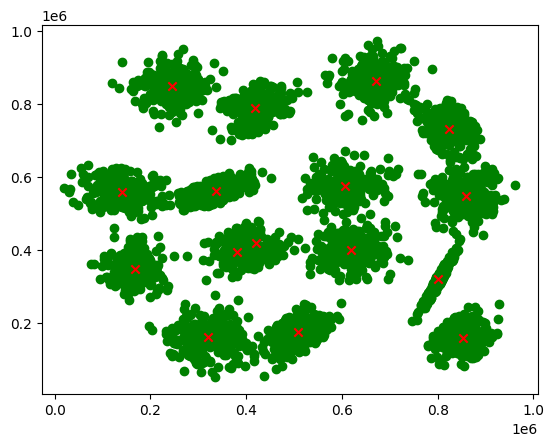

In [117]:
# Create an overlaid scatter plot of clusters and centroids
plt.scatter(rdd_split_int_df_pandas["col1"], rdd_split_int_df_pandas["col2"],color='green', marker='o')
plt.scatter(cluster_centers_pandas["col1"], cluster_centers_pandas["col2"], color="red", marker="x")
plt.show()